### Data Load

In [ ]:
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, make_scorer

# Carregar o dataset
df = pd.read_csv("../data/rent.csv")

# Separar features (X) e target (y)
X = df.drop("price", axis=1) 
y = df["price"]

### 5)

/home/pedro/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/tmp/ipykernel_2399/516653073.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


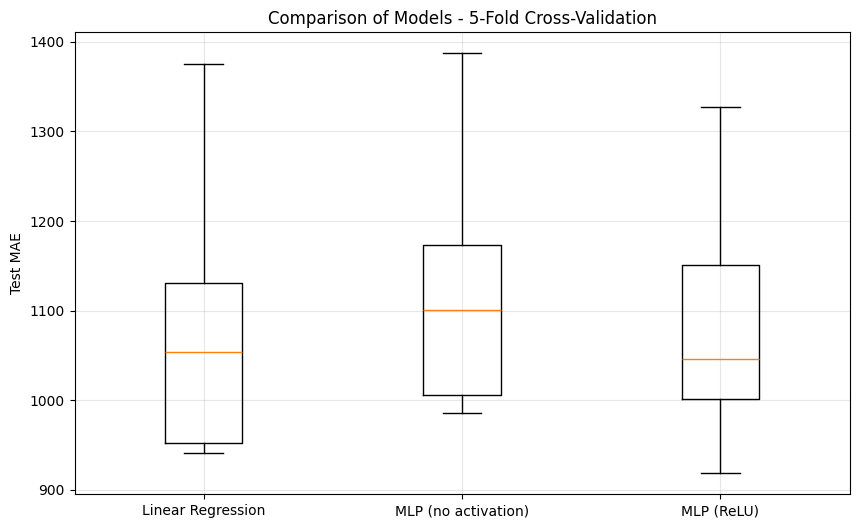

Mean Test MAE:
Linear Regression: 1090.64 +- 158.47
MLP (no activation): 1130.35 +- 145.14
MLP (ReLU): 1088.79 +- 141.10


In [5]:
# Modelo 1: Regressão Linear
model1 = LinearRegression()

# Modelo 2: MLP sem funções de ativação 
model2 = MLPRegressor(
    hidden_layer_sizes=(5, 5),  
    activation="identity",  
    max_iter=1000,
    random_state=42,
)

# Modelo 3: MLP com ReLU
model3 = MLPRegressor(
    hidden_layer_sizes=(5, 5),  
    activation="relu",  
    max_iter=1000,
    random_state=42,
)


# Definir o scorer para MAE
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Fazer cross-validation para cada modelo
cv_results1 = cross_validate(
    model1, X, y, cv=5, scoring=mae_scorer, return_train_score=True
)

cv_results2 = cross_validate(
    model2, X, y, cv=5, scoring=mae_scorer, return_train_score=True
)

cv_results3 = cross_validate(
    model3, X, y, cv=5, scoring=mae_scorer, return_train_score=True
)

# Extrair os MAE (converter para positivo)
mae1 = -cv_results1["test_score"]
mae2 = -cv_results2["test_score"]
mae3 = -cv_results3["test_score"]

# Preparar os dados para o boxplot
data = [mae1, mae2, mae3]
labels = ["Linear Regression", "MLP (no activation)", "MLP (ReLU)"]

# Criar o boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=labels)
plt.ylabel("Test MAE")
plt.title("Comparison of Models - 5-Fold Cross-Validation")
plt.grid(True, alpha=0.3)
plt.show()

print("Mean Test MAE:")
print(f"Linear Regression: {mae1.mean():.2f} +- {mae1.std():.2f}")
print(f"MLP (no activation): {mae2.mean():.2f} +- {mae2.std():.2f}")
print(f"MLP (ReLU): {mae3.mean():.2f} +- {mae3.std():.2f}")

### 6)

The Linear Regression model achieved a mean test MAE of 1090.64 ± 158.47, while the MLP with ReLU activation performed similarly with 1088.79 ± 141.10. The MLP without activation functions had worse performance, with a mean MAE of 1130.35 ± 145.14.

These results make sense when we consider how neural networks work. An MLP without activation functions is basically just a linear model, no matter how many layers we add. This happens because when we stack linear transformations on top of each other, the result is still linear. So this model can't learn nonlinear patterns in the data, which limits what it can do. The slightly worse performance compared to Linear Regression is probably because it has more parameters to optimize during training, which makes it harder to converge properly, without giving any real advantage.

The MLP with ReLU activation is different because it adds nonlinearity to the model. This means it can learn more complex relationships between the features and the rent prices. However, in our case, the improvement over Linear Regression is quite small, which suggests that the relationship in this dataset is mostly linear anyway. Still, the MLP with ReLU shows slightly lower variability across the different folds (±141.10 vs ±158.47), which indicates it generalizes a bit better.

### 7)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import pandas as pd

# --- 1. Carregar dados ---
# Substituir pelo caminho correto
data = pd.read_csv("rent.csv")
X = data.drop(columns=["price"]).values
y = data["price"].values

# --- 2. Pré-processamento ---
scaler = StandardScaler()
X = scaler.fit_transform(X)

# --- 3. Definir MLP ---
mlp = MLPRegressor(
    hidden_layer_sizes=(5, 5),
    activation="relu",
    solver="adam",
    learning_rate_init=0.01,
    max_iter=1,  # vamos treinar iterativamente
    warm_start=True,  # para continuar treinamento no loop
)

# --- 4. K-Fold ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
n_epochs = 200

train_losses = []
val_losses = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    train_loss_fold = []
    val_loss_fold = []

    # Re-inicializar pesos
    mlp._initialize(Y=y_train, X=X_train)

    for epoch in range(n_epochs):
        mlp.fit(X_train, y_train)

        y_train_pred = mlp.predict(X_train)
        y_val_pred = mlp.predict(X_val)

        train_loss_fold.append(mean_squared_error(y_train, y_train_pred))
        val_loss_fold.append(mean_squared_error(y_val, y_val_pred))

    train_losses.append(train_loss_fold)
    val_losses.append(val_loss_fold)

# --- 5. Média entre folds ---
train_loss_mean = np.mean(train_losses, axis=0)
val_loss_mean = np.mean(val_losses, axis=0)

# --- 6. Plot ---
plt.figure(figsize=(8, 5))
plt.plot(train_loss_mean, label="Treino")
plt.plot(val_loss_mean, label="Validação")
plt.xlabel("Épocas")
plt.ylabel("Loss (MSE)")
plt.title("Curvas de perda - MLP com ReLU")
plt.legend()
plt.grid()
plt.show()

# --- 7. Análise ---
if val_loss_mean[-1] > train_loss_mean[-1] * 1.5:
    print("Possível overfitting: validação bem pior que treino.")
elif train_loss_mean[-1] > 1.5 * val_loss_mean[-1]:
    print("Possível underfitting: ambos altos ou modelo mal treinado.")
else:
    print("Boa generalização: curvas próximas.")

Processing fold 1/5...


/home/pedro/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/pedro/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/pedro/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/pedro/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/pedro/.local/lib/python3.10/site-packages/sklearn/neur